In [4]:
import os, math, sys
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import simtk.unit as unit
from tqdm import tqdm

import torch.nn as nn
import torch
# import openmmtools
from openmmtorch import TorchForce
from copy import deepcopy
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis.analysis.dihedrals import Dihedral

### Citing: Most of the openmm data needed for butane and format of this notebook comes from [here](https://fastmbar.readthedocs.io/en/latest/butane_PMF.html).

In [5]:
# Indicates whether to run a simulation or not
SIMULATE = False

In [7]:
psf = omm_app.CharmmPsfFile('../data/butane.psf')
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology
params = omm_app.CharmmParameterSet('../data/top_all35_ethers.rtf',
                                    '../data/par_all35_ethers.prm')
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)
with open("../data/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))
    ## read the OpenMM system of butane
with open("../data/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("../data/butane.psf")
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

# Collective variables

In [8]:
# feature map 
def compute_gram_matrix_recentered(x):
    # n_atoms = int(x.shape[0]/3)
    # coords = x.reshape((n_atoms,3))
    rescaled_coords = x - torch.mean(x,dim=0).reshape(1,3)
    gram = torch.matmul(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True   

def butane_featurizer_map(x): 
    x = x[mask,...]
    rescaled_coords = x - torch.mean(x,dim=0).reshape(1,3)
    gram = torch.matmul(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

feature_map = torch.vmap(butane_featurizer_map)

## Plain old dihedral angle. 

In [9]:
carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True

In [10]:
def dihedral_angle_torch(x):
    carbons = x[[3,6,9,13],:]
    vectors = carbons[1:,:] - carbons[:-1,:]
    na = torch.cross(-vectors[0,:], vectors[1,:])
    nb = torch.cross(-vectors[1,:], vectors[2,:])
    xx = torch.dot(na, nb)
    xp = torch.cross(na,nb)
    yy = torch.dot(vectors[1,:],xp)/torch.norm(vectors[1,:])
    angle = torch.atan2(yy,xx)
    return angle 

In [11]:
dihedral_angle_map = torch.vmap(dihedral_angle_torch)

In [12]:
# build dihedral angle module 
class dihedral_CV(torch.nn.Module): 
    def __init__(self, forward_map): 
        super().__init__()
        self.forward_map = forward_map
    def forward(self,x): 
        angle = self.forward_map(x)
        return torch.Tensor([torch.cos(angle), torch.sin(angle)])

class CV_test(torch.nn.Module): 
    def __init__(self, cv, idx): 
        super().__init__()
        self.cv = cv
        self.idx = idx
    def forward(self,x): 
        cv_val = self.cv(x)[self.idx].flatten()
        return cv_val

## Norm squared of diffusion net

In [8]:
device = 'cuda:0'

In [13]:
def rotate_xy(xy_recentered, theta):
    """
    Rotates each row of the input n x 3 matrix by the given angle theta (rotation in the XY plane).

    Args:
    xy_recentered (torch.Tensor): An n x 3 matrix where each row is a 3D vector.
    theta (float or torch.Tensor): The rotation angle in radians.

    Returns:
    torch.Tensor: An n x 3 matrix with each row rotated by the given angle.
    """
    # Initialize the output tensor with the same shape as the input
    xy_rotated = torch.zeros_like(xy_recentered)

    # Calculate cosine and sine of the rotation angle
    cos_theta = torch.cos(-theta)
    sin_theta = torch.sin(-theta)

    # Loop through each row to apply the rotation
    for i in range(xy_recentered.shape[0]):
        # Extract the x, y, z components of the current row
        x = xy_recentered[i, 0]
        y = xy_recentered[i, 1]
        z = xy_recentered[i, 2]

        # Apply 2D rotation to the x and y coordinates (rotation around Z-axis)
        new_x = cos_theta * x - sin_theta * y
        new_y = sin_theta * x + cos_theta * y
        new_z = z  # z remains unchanged

        # Store the rotated values in the output tensor
        xy_rotated[i, 0] = new_x
        xy_rotated[i, 1] = new_y
        xy_rotated[i, 2] = new_z

    return xy_rotated

def rotate_zx(xy_recentered, theta):
    """
    Rotates each row of the input n x 3 matrix by the given angle theta (rotation in the ZX plane).

    Args:
    xy_recentered (torch.Tensor): An n x 3 matrix where each row is a 3D vector.
    theta (float or torch.Tensor): The rotation angle in radians.

    Returns:
    torch.Tensor: An n x 3 matrix with each row rotated in the ZX plane by the given angle.
    """
    # Initialize the output tensor with the same shape as the input
    xy_rotated = torch.zeros_like(xy_recentered)

    # Calculate cosine and sine of the rotation angle
    cos_theta = torch.cos(-theta)
    sin_theta = torch.sin(-theta)

    # Loop through each row to apply the rotation
    for i in range(xy_recentered.shape[0]):
        # Extract the x, y, z components of the current row
        x = xy_recentered[i, 0]
        y = xy_recentered[i, 1]
        z = xy_recentered[i, 2]

        # Apply 2D rotation to the x and z coordinates (rotation in the ZX plane)
        new_x = cos_theta * x - sin_theta * z
        new_z = sin_theta * x + cos_theta * z
        new_y = y  # y remains unchanged

        # Store the rotated values in the output tensor
        xy_rotated[i, 0] = new_x
        xy_rotated[i, 1] = new_y
        xy_rotated[i, 2] = new_z

    return xy_rotated

def recenter_bond_torch(x):
        x = x.reshape((4, 3))
        assert x.shape == (4, 3)
        
        recentered_x = x - x[0, :]
        theta = torch.atan2(recentered_x[1, 1], recentered_x[1, 0])
        
        xy_rotated = rotate_xy(recentered_x,theta)
        phi = torch.atan2(xy_rotated[1, 2], xy_rotated[1, 0])
        zx_rotated = rotate_zx(xy_rotated, phi)
        return zx_rotated.flatten()

xx = torch.randn((4,3))

In [15]:
class Encoder_deep(nn.Module):
    def __init__(self, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim):
        super(Encoder_deep, self).__init__()
        
        # Defining the layers of the neural network
        # self.featurizer = feature_map
        self.activation = activation
        self.hidden1 = nn.Linear(input_dim, hidden1_dim)
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.hidden3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.hidden4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.bottleneck = nn.Linear(hidden4_dim, encoder_dim)

        # Collecting layers for convenience
        self.encoder = nn.Sequential(self.hidden1, self.activation, \
                                     self.hidden2, self.activation, \
                                        self.hidden3, self.activation, \
                                            self.hidden4, self.activation, \
                                                self.bottleneck, self.activation)

    
    def encode(self, x):
        # y = self.featurizer(x)
        return self.encoder(x)
    
    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        # x = self.featurizer(x)
        return self.encode(x)

In [18]:
# this defines the structure of the model
activation = nn.Tanh() 
input_dim = 12
hidden1_dim = 32
hidden2_dim = 32
hidden3_dim = 32
hidden4_dim = 32
encoder_dim = 2
output_dim = 12
model_encoder_reg = Encoder_deep(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to('cpu')
model_encoder_reg.load_state_dict(torch.load("diffusion_net", map_location='cpu'))
model_encoder_reg.eval()

Encoder_deep(
  (activation): Tanh()
  (hidden1): Linear(in_features=12, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=32, bias=True)
  (bottleneck): Linear(in_features=32, out_features=2, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

In [19]:
carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True   
class collective_variable(nn.Module):
    def __init__(self, mask, featurizer, Dnet): 
        super().__init__()
        self.mask = mask
        self.featurizer = featurizer
        self.Dnet = Dnet
    def forward(self,x):
        x = 10*x[self.mask, :]
        x = self.featurizer(x) 
        x = self.Dnet(x.float())
        return torch.norm(x)**2

# 1.d Post-process for openMM

In [20]:
# cv_model_1 = CV_test(12, 0, mask, single = True)
# cv_model_2 = CV_test(12, 1, mask, single = True)

cv_model_2 = collective_variable(mask, recenter_bond_torch, model_encoder_reg)

In [22]:
# cv_model_1.to(device)
cv_model_2.to('cpu')
# cv1 = torch.jit.script(cv_model_1)
cv2 = torch.jit.script(cv_model_2)
# CV_force_1 = TorchForce(cv1)
CV_force_2 = TorchForce(cv2)

In [17]:
# Define Collective Variable
# cv_1 = omm.CustomCVForce("cv1")
# cv_1.addCollectiveVariable("cv1",CV_force_1)

cv_2 = omm.CustomCVForce("cv2")
cv_2.addCollectiveVariable("cv2",CV_force_2)

# Set metadynamics parameters
biasWidth=1.5e-3
# phi = omm_app.metadynamics.BiasVariable(force=cv_1, minValue=-0.1, maxValue=0.0, biasWidth=0.1, periodic=False, gridWidth=100)
# psi = omm_app.metadynamics.BiasVariable(force=cv_2, minValue=0.5, maxValue=1.3, biasWidth=0.2, periodic=False, gridWidth=100)
# psi = omm_app.metadynamics.BiasVariable(force=cv_2, minValue=-np.pi, maxValue=np.pi, biasWidth=biasWidth, periodic=True)
psi = omm_app.metadynamics.BiasVariable(force=cv_2, minValue=0.0, maxValue=0.03, biasWidth=biasWidth, periodic=False, gridWidth=1000)


# 2. Set up and run the simulation

In order to run simulations in OpenMM, we need to construct an OpenMM [context](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Context.html), which consists of a system, an integrator and a platform.
The system is the butane system we have constructed above.
The integrator specifies what kind integration method we should use. Here, we will use Langevin dynamics, which corresponds to the [OpenMM.LangevinIntegrator](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html) and the [OpenMM.LangevinMiddleIntegrator](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html). Here, we use the LangevinMiddleIntegrator based on [J. Phys. Chem. A 2019, 123, 28, 6056-6079](https://pubs.acs.org/doi/full/10.1021/acs.jpca.9b02771), closely related to the BAOAB [Proc. R. Soc. A. 472: 20160138](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.2016.0138) scheme.

The platform specifies what kind of hardware we will run simulation on. Here, we choose to use CPUs because the size of the system is quite small.

Then, we initialize a [Simulation](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.simulation.Simulation.html), an api for running simulations and reporting results.


In [26]:
T = 300 * unit.kelvin  ## temperature
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA 
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

In [18]:
platform = omm.Platform.getPlatformByName('CUDA')
T = 300 * unit.kelvin  ## temperature
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA 
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

kbT_roomtemp = unit.BOLTZMANN_CONSTANT_kB*unit.AVOGADRO_CONSTANT_NA*300.0*unit.kelvin
kbT_roomtemp = kbT_roomtemp.value_in_unit(unit.kilojoule_per_mole)

# Set up metadynamics
# biasFactor = 10
# height = 1.0
# frequency = 1E8
# meta = omm_app.Metadynamics(system, variables=[psi], temperature=T, biasFactor=biasFactor, height=height, 
#                             frequency=frequency, saveFrequency=frequency, biasDir="../output/traj_current/")
biasFactor = 10
height = 0.1
frequency = 1E7
meta = omm_app.Metadynamics(system, variables=[psi], temperature=T, biasFactor=biasFactor, height=height, \
                            frequency=frequency, saveFrequency=frequency, biasDir="../output/traj_current/")

## integrator
fricCoef = 10/unit.picoseconds ## friction coefficient 
stepsize = 2 * unit.femtoseconds ## integration step size
integrator = omm.LangevinMiddleIntegrator(T, fricCoef, stepsize)
simulation = omm_app.Simulation(topology, system, integrator, platform)

In [30]:
platform.setPropertyValue(simulation.context, 'DeviceIndex', '1')

In [45]:
# class CVreporter(object):
#     def __init__(self, file, reportInterval):
#         self._out = open(file, 'w')
#         self._reportInterval = reportInterval

#     def __del__(self):
#         self._out.close()

#     def describeNextReport(self, simulation):
#         steps = self._reportInterval - simulation.currentStep%self._reportInterval
#         return (steps, False, False, True, False, None)

#     def report(self, meta, simulation, state):
#         cvs = meta._force.getCollectiveVariableValues(simulation.context)
#         for cv in cvs:
#             self._out.write('%g %g' % (cv[0], cv[1]))
#         self._out.write('\n')
#         self._out.flush()

In [19]:
my_state = "state_NNCV.txt"
my_dcd = "traj_NNCV.dcd"
my_free_energy = "free_energy_NNCV.npz"
my_CVs = "my_CVs_NNCV.npz"
simulation.context.setPositions(pdb.positions)
if psf.boxVectors is not None:
    print("we got box vectors!")
    simulation.context.setPeriodicBoxVectors(*psf.boxVectors)
# simulation.minimizeEnergy()
simulation.reporters.append(omm_app.DCDReporter(my_dcd, int(1E1), False))
simulation.reporters.append(omm_app.StateDataReporter(my_state, 1E1, step=True, potentialEnergy=True))
simulation.reporters.append(omm_app.StateDataReporter(stdout, 1E5, step=True, potentialEnergy=True))

In [20]:
if SIMULATE:
   # simulation.minimizeEnergy()
    meta.step(simulation, 1E7)
    np.savez(my_free_energy, free_energy=meta.getFreeEnergy())
    np.savez(my_CVs, CVs = meta.getCollectiveVariables(simulation))

#"Step","Potential Energy (kJ/mole)"
100000,75.33720051691257
200000,79.54058486032127
300000,96.38149423201023
400000,68.75064946941328


KeyboardInterrupt: 

In [32]:
biases = np.load("bias_NNCV.npy")
# free_energy = np.load("../output/traj_current/free_energy_jul7.npz")['free_energy']

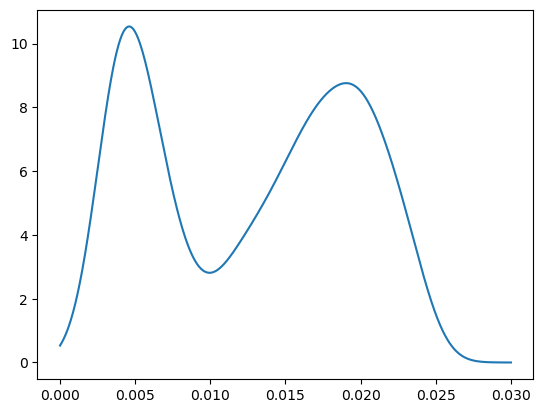

In [33]:
plt.plot(np.linspace(0.0,0.03,1000),biases)